In [55]:
"""
Importing required libraries
"""
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_samples
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
from time import time
from scipy.io.arff import loadarff 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
import os
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
random_state = np.random.RandomState(17)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dataset 
Refrence:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Dataset Attribute Information:
Dataset name: Heart Data
following description of fetures are obtainbed from:
https://www.kaggle.com/ronitf/heart-disease-uci

c indicates whether feature is categorical
+ age
+ C-sex
+ C-chest pain (4 values)
+ blood pressure
+ cholestoral 
+ C-fasting blood sugar 
+ C-ecg results (values 0,1,2)
+ max heart rate
+ C-exercise induced angina
+ oldpeak 
+ C-the slope of ST segment
+ number of vessels (0-3) colored 
+ C-thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [2]:
heart_data_path = os.path.join("Data", "heart_disease/heart.csv")
heart = pd.read_csv(heart_data_path)
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [3]:
heart["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

## Load/Split/Process Data:

In [4]:
heart_train_set, heart_test_set = train_test_split(heart, test_size=0.2, random_state=17)
# Separate predictors and labels for heart data
heart_train_features = heart_train_set.drop("target",axis=1)
y = heart_train_set["target"].copy()
# identifying the categorical and numerical data for heart data
heart_cat_attrs = ["sex","cp","fbs","restecg","exang","slope","thal"]
heart_num_attrs = ["age","trestbps","chol","thalach","oldpeak","ca"]
# pipe line for preprocessing
pipeline = ColumnTransformer([
        ("num", StandardScaler(), heart_num_attrs),
        ("cat", OneHotEncoder(), heart_cat_attrs),
    ])
    
X = pipeline.fit_transform(heart_train_features)

# Heart test set preprocessing
heart_test_features = heart_test_set.drop("target",axis=1)
heart_test_prep = pipeline.transform(heart_test_features)
heart_test_labels = heart_test_set["target"].copy()

In [46]:
def plot_clusters(X, y=None,s=4):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X,y_true=None):
    plt.scatter(X[:, 0], X[:, 1], c=y_true,s=3)
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X,y_true=None, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y_true)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


Saving figure heart_plot


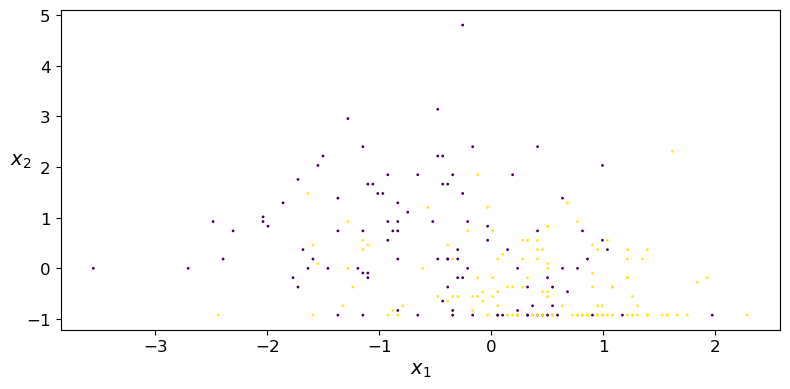

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X[:,3:],y)
save_fig("heart_plot")
plt.show()

# Dimensionality Reduction (DR)

## LLE:

### Optimum LLE dimensions

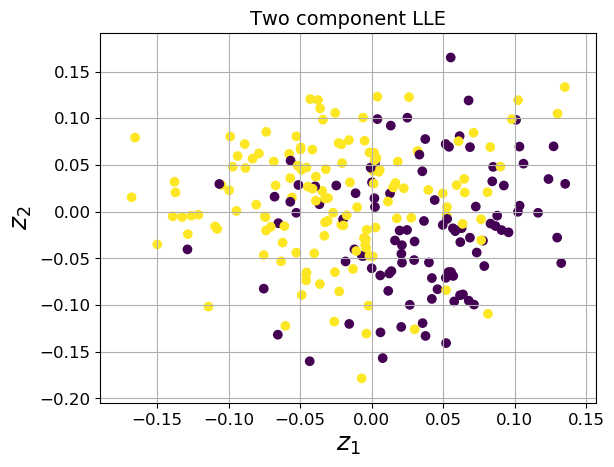

In [10]:
plt.title("Two component LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)#, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

# save_fig("lle_unrolling_plot")
plt.show()

### Reconstruction Error

In [11]:
error =[]
for nn in [27,40,50]:
    temp=[]
    for rand in range(10):
        lle_per_comp = [LocallyLinearEmbedding(n_components=k, n_neighbors=nn,method='modified', random_state=0).fit(X) for k in range(1,X.shape[1]+1)]

        temp_errors = [lle.reconstruction_error_ for lle in lle_per_comp]
        temp.append(temp_errors)
    error.append(temp)

In [12]:
errors = [np.mean(np.array(err),axis=0) for err in error] 

LLE modified method require the number of neighbors to be more than the n_component and since max dimension is 26, 27 was selected for the number of neighbors

Saving figure LLE_heart_reconstruct_error_plot


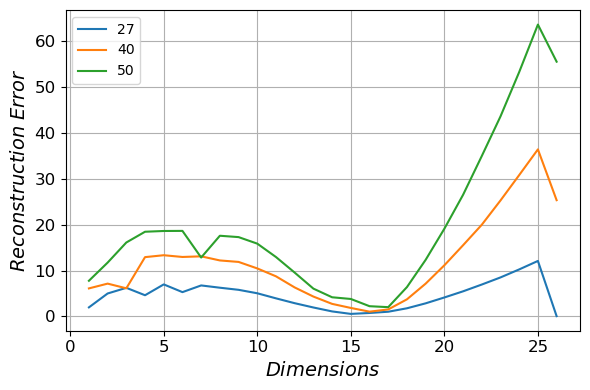

26

In [13]:
plt.figure(figsize=(6,4))
num_n = [27,40,50]
for er,label in zip(errors,num_n):
    plt.plot(np.arange(1,X.shape[1]+1),er,label = label)
min_point = np.argmin(errors)
d = min_point+1
plt.xlabel("$Dimensions$")
plt.ylabel("$Reconstruction$ $Error$")
plt.grid(True)
plt.legend()
save_fig("LLE_heart_reconstruct_error_plot")
plt.show()

d

In [14]:
d=15
lle = LocallyLinearEmbedding(n_components=d, n_neighbors=27,method='modified', random_state=0)
X_reduced = lle.fit_transform(X)

# Clustering: 

In [15]:
X_DR = X_reduced.copy()

# 1- _K-Means_

### Optimum Number of Clusters

### Elbow Method:

In [16]:
kmeans_with_var_k = [KMeans(n_clusters=k, random_state=9).fit(X_DR) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_with_var_k]

Saving figure LLE_heart_inertia_vs_k_plot


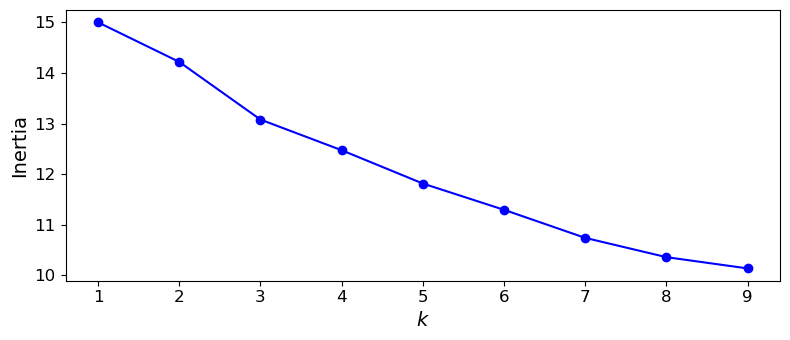

In [17]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

save_fig("LLE_heart_inertia_vs_k_plot")
plt.show()

### Silhouette score :

In [18]:
silhouette_scores = [silhouette_score(X_DR, model.labels_) for model in kmeans_with_var_k[1:]]

Saving figure LLE_heart_silhouette_score_vs_k_plot


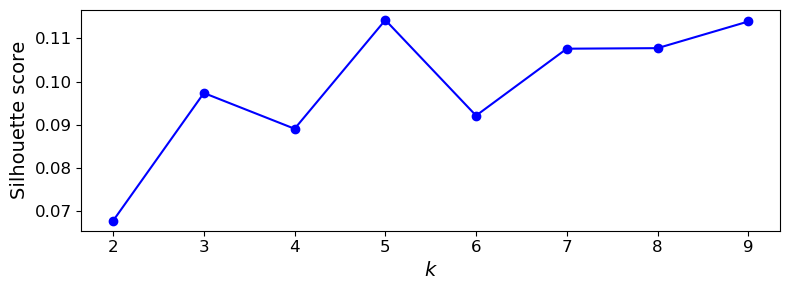

In [19]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("LLE_heart_silhouette_score_vs_k_plot")
plt.show()

Based on the result there is not clear Elbow in inertia plot (maybe k=3) but the silhouette score for k=5 and k=9 will result in the max score based on these result I consider k=3 as the optimum number of clusters

Saving figure LLE_heart_silhouette_analysis_plot


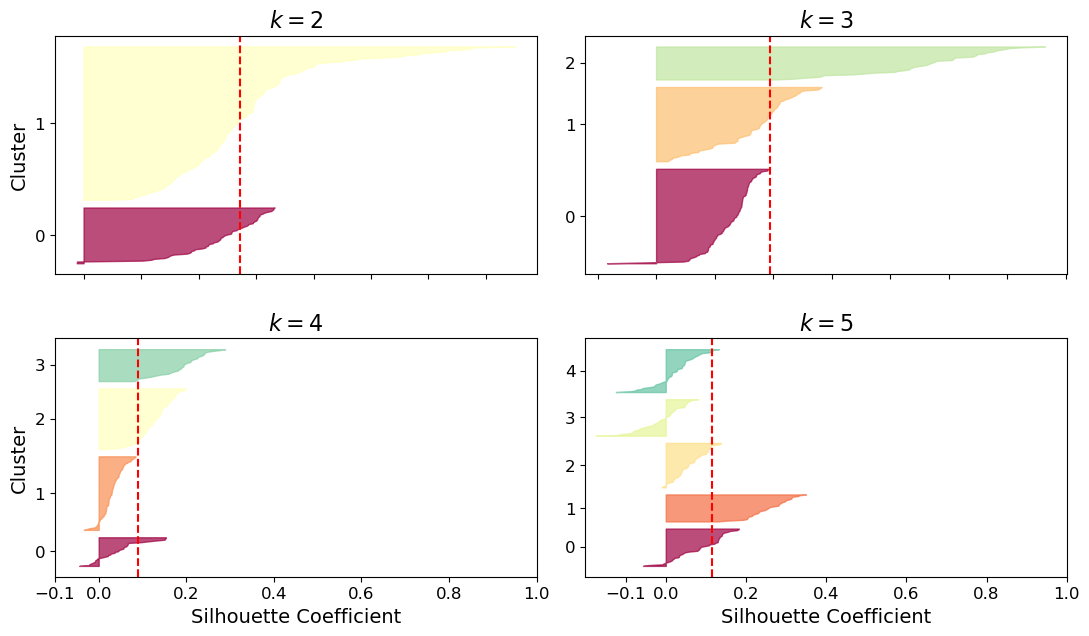

In [54]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(3, 2, k - 1)
    
    y_pred = kmeans_with_var_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_DR, y_pred)

    padding = len(X_DR) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("LLE_heart_silhouette_analysis_plot")
plt.show()

Based on the silhouette diagram it appears k=4 and k=5 will result in better clusters while k=1 and 2 have clusters with negative coefficient which indicate the higher probability of the instances assigned to the wrong cluster while for the k=6 we have clusters with silhouette coefficients less than the silhouette score. based on this we use k=4 since it results in most of the clustes having similar sized while its score is slightly less than the k=4


In [21]:
# Model with optimnal k value
kmeans_optimum = kmeans_with_var_k[4]
y_pred = kmeans_optimum.fit_predict(X_DR)
# kmeans_optimum.cluster_centers_

### Evaluation

In [22]:
# adjusted_mutual_info_score
adjusted_mutual_info_score(y,y_pred)

0.10115102029702323

In [23]:
# adjusted Rand index
adjusted_rand_score(y,y_pred)

0.08995715958017521

In [24]:
# Homogeneity,
# homogeneity: 
# completeness: 
# V-measure: 
homogeneity_completeness_v_measure(y,y_pred)

(0.17784697181473072, 0.07737968947461897, 0.10783938780928164)

Computing t-SNE embedding


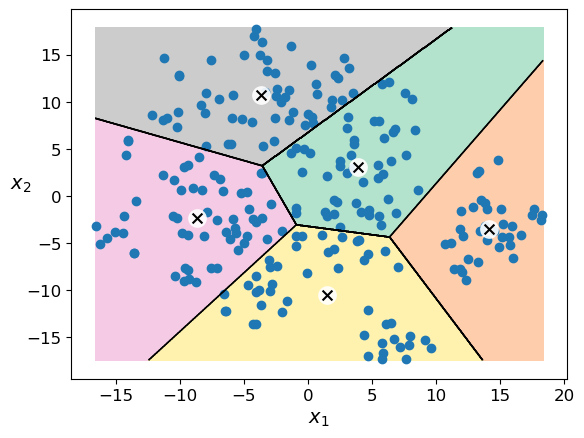

In [25]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_DR)
kmeans = KMeans(n_clusters=5, random_state=9)
# y_pred_tsne = kmeans.fit_predict(X_tsne)
kmeans.fit(X_tsne)
y_pred_tsne = kmeans_optimum.fit_predict(X_tsne)
# plot_decision_boundaries(kmeans,X_tsne,y)
plot_decision_boundaries(kmeans,X_tsne)


In [26]:
pca_viz = PCA(n_components=2)
pca_viz.fit(X_DR)
X_DR_pca_viz = pca_viz.fit_transform(X_DR)

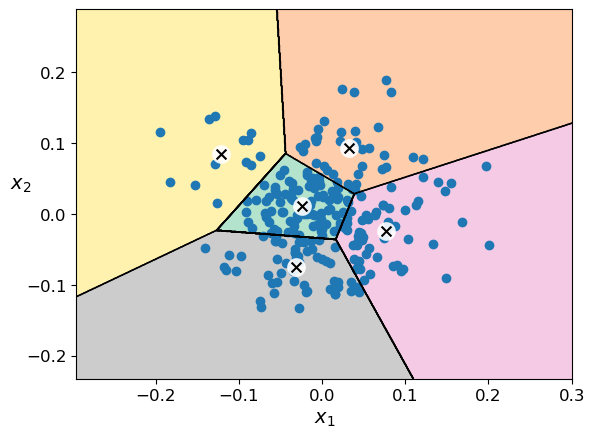

In [27]:
kmeans_pca_viz = KMeans(n_clusters=5, random_state=9)
kmeans_pca_viz.fit(X_DR_pca_viz)
plot_decision_boundaries(kmeans_pca_viz,X_DR_pca_viz)


Saving figure LLE_heart_K_means_cluster_TsnE


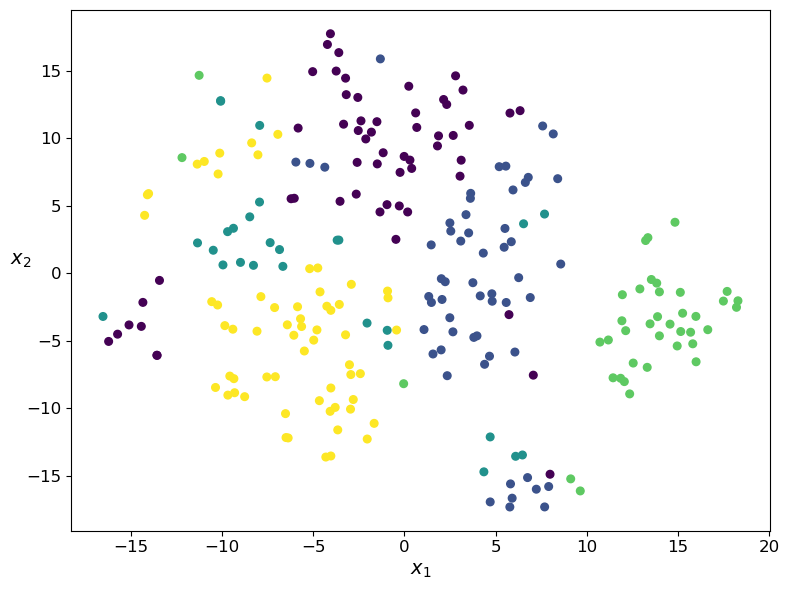

In [47]:
plot_clusters(X_tsne,y_pred,s=30)
save_fig("LLE_heart_K_means_cluster_TsnE")

Saving figure LLE_heart_K_means_cluster_PCA


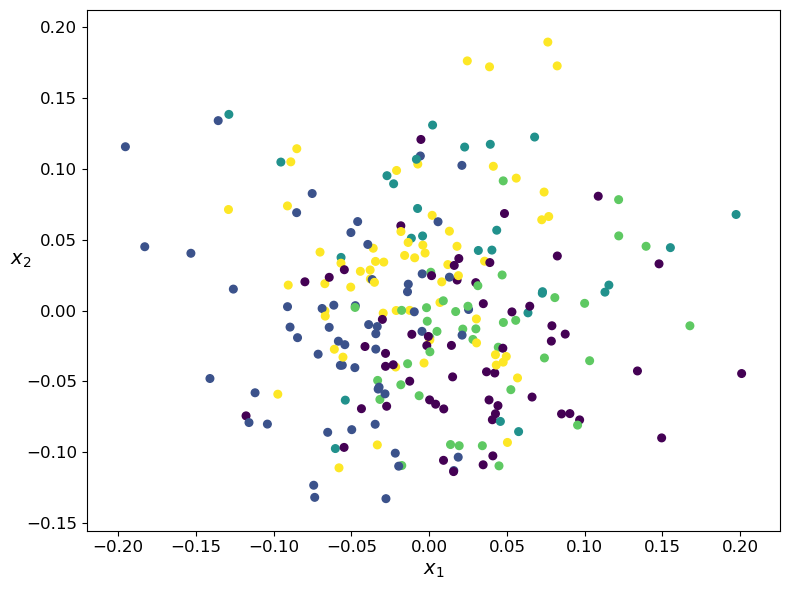

In [48]:
plot_clusters(X_DR_pca_viz,y_pred,s=30)
save_fig("LLE_heart_K_means_cluster_PCA")

# 2- _Gaussian Mixture (EM)_

In [30]:
g_mix = GaussianMixture(n_components=3, n_init=10, random_state=42)
g_mix.fit(X_DR)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

### Optimum Number of Clusters

In [31]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X_DR) for k in range(1, 11)]

In [32]:
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]

Saving figure LLE_heart_aic_bic_vs_k_plot


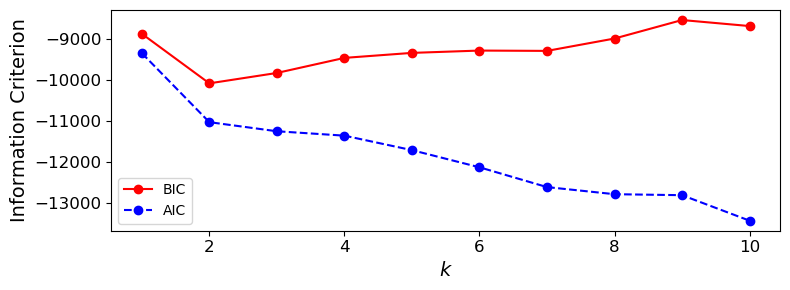

In [33]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 11), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()
save_fig("LLE_heart_aic_bic_vs_k_plot")
plt.show()

Based on the above plot BIC is min at k=2 while AIC is min at k=8 - While model with min BIC is simpler it might not fit the data quite well. We can evaluate this further since we have the labels for the data.

In [34]:
bic_per_k[1],aics_per_k[1]

(-10090.39453596148, -11035.896659749942)

In [49]:
min_bic = np.infty
cov_type = ["full", "tied", "spherical", "diag"]
bic_lst = {"full":[], "tied":[], "spherical":[], "diag":[]}
for k in range(1, 11):
    temp=[]
    for covariance_type in cov_type:
        gm = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=9).fit(X_DR)
        bic = gm.bic(X_DR)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
            best_gm=gm
        bic_lst[covariance_type].append(bic)

best_k,best_covariance_type

(10, 'tied')

In [50]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)

    bar_width = total_width / n_bars

    bars = []

    for i, (name, values) in enumerate(data.items()):
  
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

Saving figure LLE_heart_bic_vs_k


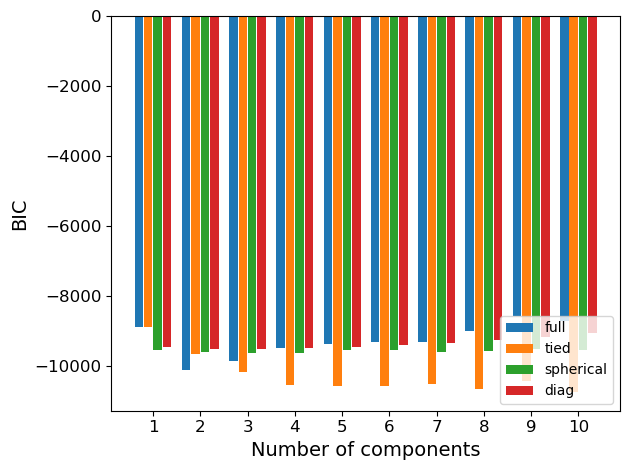

In [51]:
fig, ax = plt.subplots()
n_comp=np.arange(1, 11)
ax.set_xticks(np.arange(len(bic_lst['full'])))
ax.set_xticklabels(n_comp)
bar_plot(ax, bic_lst, total_width=.8, single_width=.9)

plt.xlabel('Number of components')
plt.ylabel('BIC')
save_fig("LLE_heart_bic_vs_k")
plt.show()

Saving figure LLE_heart_aic_bic_vs_k_plot_optimum


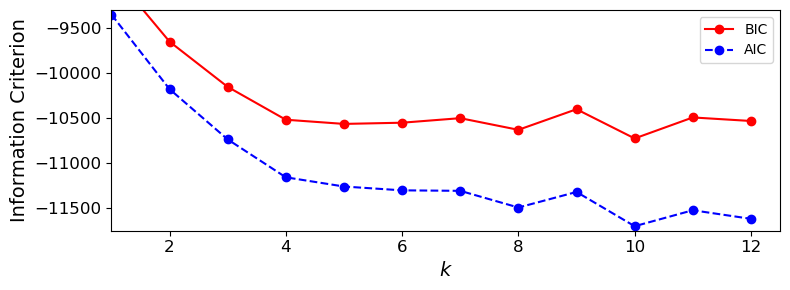

In [37]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10,covariance_type='tied', random_state=9).fit(X_DR) for k in range(1, 13)]
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]
plt.figure(figsize=(8, 3))
plt.plot(range(1, 13), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 13), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 12.5, np.min(aics_per_k) - 50, np.max(aics_per_k) + 50])
plt.legend()
save_fig("LLE_heart_aic_bic_vs_k_plot_optimum")
plt.show()

It seems the minimium value for both agrees at k=6 while for AIC the k=9 result to a slighltly lower value it is reasonable to go with the k=10

In [38]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=9)
bgm.fit(X_DR)
np.round(bgm.weights_, 2)

array([0.11, 0.13, 0.04, 0.05, 0.1 , 0.14, 0.15, 0.09, 0.07, 0.13])

## Optimum Model

In [39]:
gm_optimum = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_DR)
y_pred_gm = gm_optimum.predict(X_DR)

## Evaluation

In [40]:
# adjusted_mutual_info_score
adjusted_mutual_info_score(y,y_pred_gm)

0.1305279365869755

In [41]:
# adjusted Rand index
adjusted_rand_score(y,y_pred_gm)

0.09695012158172481

In [42]:
# Homogeneity, completeness and V-measure
homogeneity_completeness_v_measure(y,y_pred_gm)

(0.2774529304289559, 0.09728977476940848, 0.14406328788311953)

In [43]:
def plot_gaussian_mixture(clusterer, X,y_true = None, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    ax.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    

    scatter = ax.scatter(X[:, 0], X[:, 1],c=y_true if y_true is not None else 'k'
     ,s=4)

    # produce a legend with the unique colors from the scatter
    if y_true is not None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
        ax.add_artist(legend1)
    # plt.scatter(X[:, 0], X[:, 1],c=y,s=)

    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure LLE_heart_gaussian_mixtures


<Figure size 800x400 with 0 Axes>

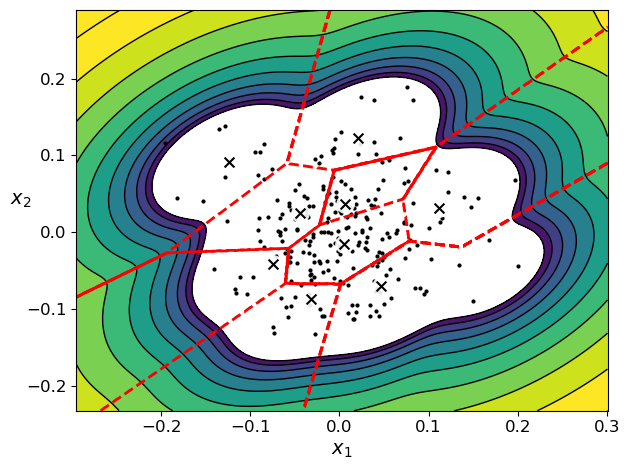

In [44]:
plt.figure(figsize=(8, 4))
gm_viz = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_DR_pca_viz)
plot_gaussian_mixture(gm_viz, X_DR_pca_viz)

save_fig("LLE_heart_gaussian_mixtures")
plt.show()

Saving figure LLE_heart_gaussian_mixtures_cluster_TsnE


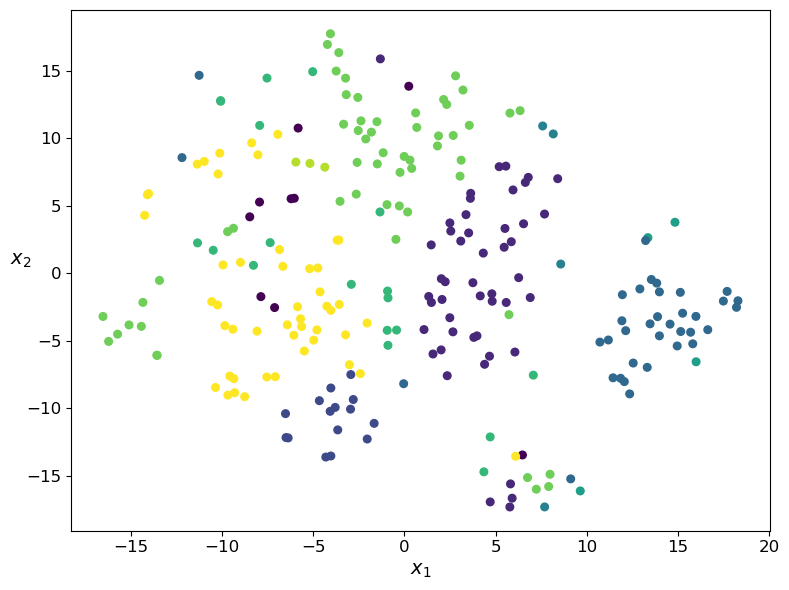

In [52]:
plot_clusters(X_tsne,y_pred_gm,s=30)
save_fig("LLE_heart_gaussian_mixtures_cluster_TsnE")

Saving figure LLE_heart_gaussian_mixtures_cluster_PCA


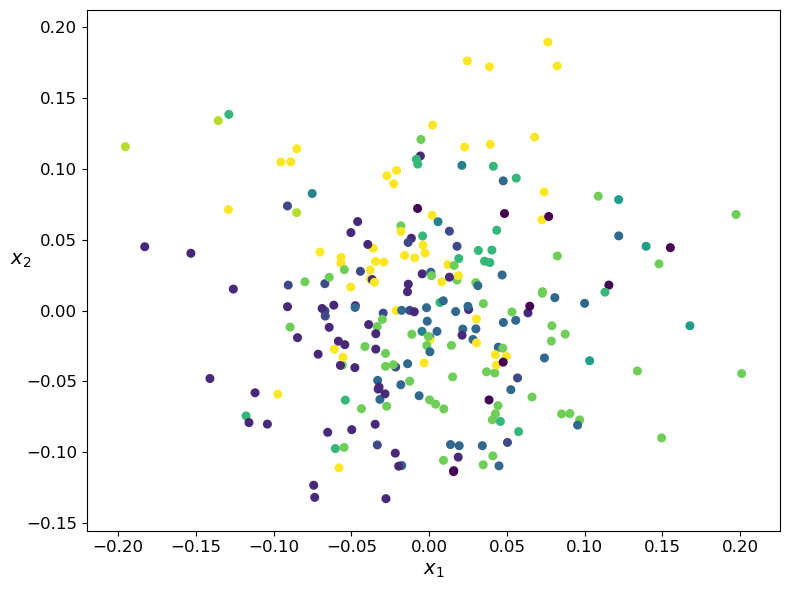

In [53]:
plot_clusters(X_DR_pca_viz,y_pred_gm,s=30)
save_fig("LLE_heart_gaussian_mixtures_cluster_PCA")